# AutoEncoders for Task2 (unsupervised NeuralNets)

In [1]:
# Generative Models

# Loss func: reconstructed image v close to original, constrained on size for example.

# For each transformation in the original layer, we want to decode it back.

# e.g. nn.Linear back and forth, or nn.Conv2d and nn.ConvTranspose2d back

# tricky thing is to just determine the input and output sizes.

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Loading MNIST Data for practice

In [3]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64,shuffle=True)

100%|██████████| 9912422/9912422 [00:15<00:00, 653118.43it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1227610.50it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:02<00:00, 728491.61it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4538001.14it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# Creating an AutoEncoder class with only linear layers

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,784),
            nn.Sigmoid() # since our input values are between 0 and 1, we apply sigmoid
        )
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [7]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001, weight_decay=0.000001)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Trying out the Autoencoder class

In [11]:
model.to(device)
epochs = 15
outputs = []
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    for img,_ in data_loader:
        img = img.to(device)
        img = img.reshape(-1,784)
        model.train()
        recon = model(img)
        cost = criterion(recon,img)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        # model.eval()
    print(f'Epoch:{epoch+1}, cost: {cost.item():.4f}')
    outputs.append((epoch,img,recon))

  7%|▋         | 1/15 [00:14<03:19, 14.26s/it]

Epoch:1, cost: 0.0409


 13%|█▎        | 2/15 [00:28<03:02, 14.03s/it]

Epoch:2, cost: 0.0407


 20%|██        | 3/15 [00:42<02:50, 14.21s/it]

Epoch:3, cost: 0.0374


 27%|██▋       | 4/15 [00:56<02:36, 14.26s/it]

Epoch:4, cost: 0.0362


 33%|███▎      | 5/15 [01:11<02:22, 14.28s/it]

Epoch:5, cost: 0.0367


 40%|████      | 6/15 [01:25<02:08, 14.26s/it]

Epoch:6, cost: 0.0345


 47%|████▋     | 7/15 [01:39<01:53, 14.22s/it]

Epoch:7, cost: 0.0336


 53%|█████▎    | 8/15 [01:53<01:39, 14.25s/it]

Epoch:8, cost: 0.0359


 60%|██████    | 9/15 [02:07<01:25, 14.19s/it]

Epoch:9, cost: 0.0317


 67%|██████▋   | 10/15 [02:22<01:10, 14.18s/it]

Epoch:10, cost: 0.0342


 73%|███████▎  | 11/15 [02:36<00:56, 14.16s/it]

Epoch:11, cost: 0.0295


 80%|████████  | 12/15 [02:50<00:42, 14.28s/it]

Epoch:12, cost: 0.0327


 87%|████████▋ | 13/15 [03:04<00:28, 14.26s/it]

Epoch:13, cost: 0.0268


 93%|█████████▎| 14/15 [03:19<00:14, 14.28s/it]

Epoch:14, cost: 0.0304


100%|██████████| 15/15 [03:33<00:00, 14.22s/it]

Epoch:15, cost: 0.0336


# Visualizing the model's output of image reconstruction

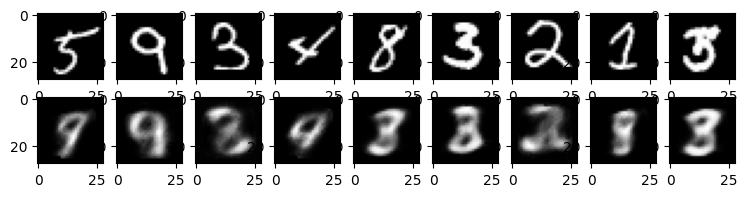

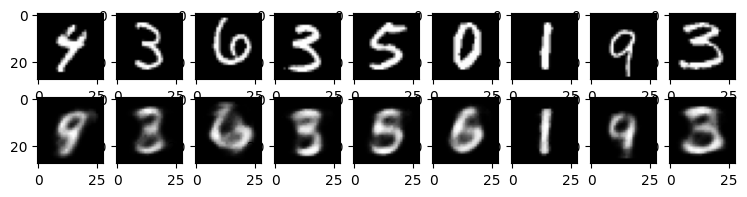

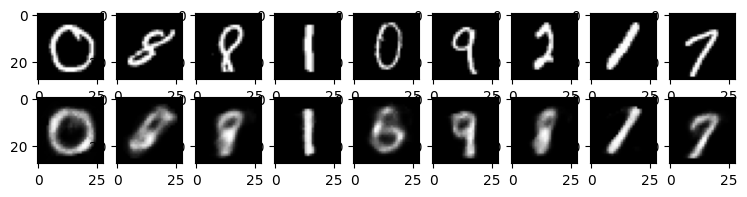

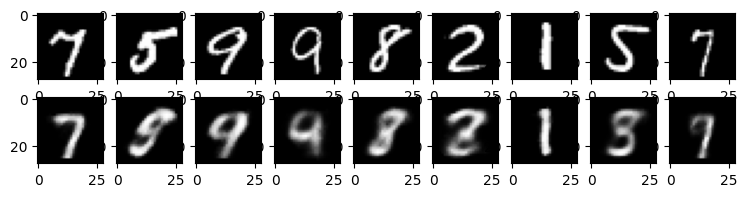

In [23]:
for k in range(0, epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

# AutoEncoder with Convolutional layers

In [66]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # starts off with 1 x 28 x 28 picture
            nn.Conv2d(1,16,3,2,1), # applies conv filter and makes it 16 x 14 x 14 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # makes it 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32,64,7), # makes it 64 x 1 x 1 (since kernel size is 7)
            nn.MaxPool2d(kernel_size=1, return_indices=True)
        )
        self.decoder = nn.ModuleList([
            nn.MaxUnpool2d(kernel_size=1),  # Use indices for unpooling
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        ])
    def forward(self,x):
        x, indices = self.encoder(x)
        
        # Apply unpooling
        x = self.decoder[0](x, indices)
        
        # Apply the rest of the decoder layers
        for layer in self.decoder[1:]:
            x = layer(x)
        
        return x

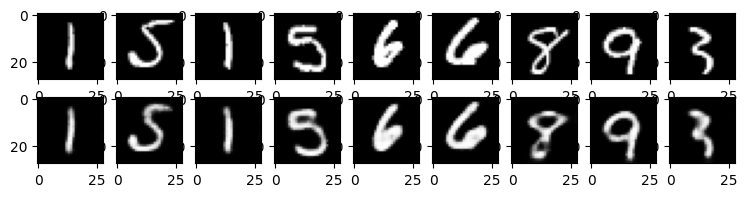

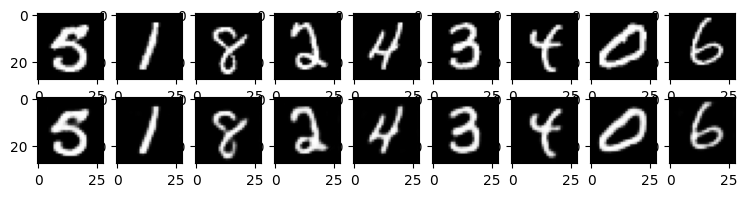

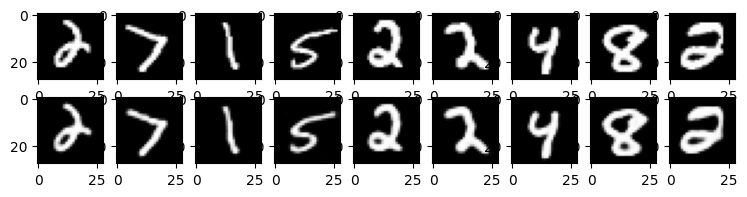

In [30]:
# without MaxPool
for k in range(0, epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

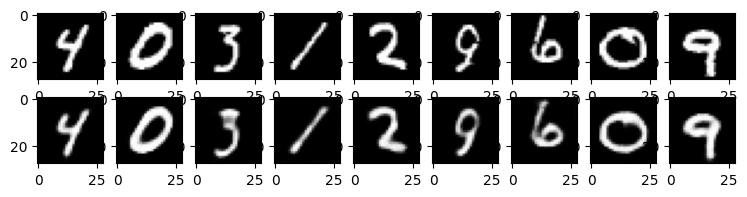

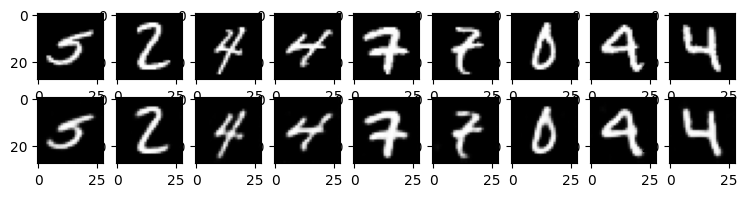

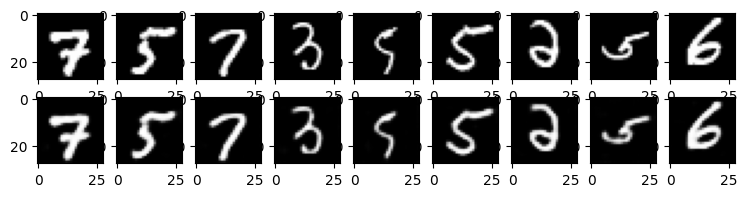

In [48]:
# with MaxPool: 
for k in range(0, epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

# Now, on to Task 2

In [234]:
import torch
from torch import nn
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # starts off with 1 x 250 x 100 picture
            nn.Conv2d(1,16,3,2,1), # applies conv filter and makes it 16 x 14 x 14 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # makes it 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32,64,7) # makes it 64 x 1 x 1 (since kernel size is 7)
            # nn.MaxPool2d(kernel_size=1, return_indices=True)
        )
        self.decoder = nn.ModuleList([
            # nn.MaxUnpool2d(kernel_size=1),  # Use indices for unpooling
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        ])
    def forward(self,x):
        x = self.encoder(x)
        
        # Apply unpooling
        # x = self.decoder[0](x, indices)
        
        # Apply the rest of the decoder layers
        for layer in self.decoder[0:]:
            x = layer(x)
        
        return x

In [236]:
image_dir = "E:/Data/seg/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images"
import glob, cv2
import numpy as np
img_paths = glob.glob(image_dir + '/*.png')
def preprocessing(image,mask):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Set a consistent resolution for the cropped images and masks
  desired_resolution = (240,180)
  cropped_gray_image = cv2.resize(gray_image, desired_resolution)
  cropped_mask = cv2.resize(mask, desired_resolution)
  return np.array(cropped_gray_image)/255, np.array(cropped_mask)/255
data = []
ground_truths = []
for path, path2 in zip(img_paths, ground_truths_dir):
    image, mask = preprocessing(cv2.imread(path, cv2.IMREAD_COLOR), cv2.imread(path2, cv2.IMREAD_GRAYSCALE))
    data.append(image)
    ground_truths.append(mask)

In [237]:
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
class CustomDataset(Dataset):
    def __init__(self, data, truths, transform=None):
        self.data = data
        self.truths = truths
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.truths[idx]
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        return img, label

X_train, X_test, y_train, y_test = train_test_split(data, ground_truths, test_size=0.2)
train_dataset = CustomDataset(data=X_train, truths=y_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = CustomDataset(data=X_test, truths=y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [244]:
def train_model_loop(model, epochs, loss, optimizer, device, train_loader, test_loader):
    '''model refers to the architecture class.
    loss refers to the loss function
    'a' refers to the accuracy function'''
    outputs=[]
    model.to(device)
    from tqdm import tqdm
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        for X_train, y_train in train_loader:
            # print(y_train.shape)
            img,truth = X_train.float().unsqueeze(dim=1).to(device), y_train.float().unsqueeze(dim=1).to(device)
            model.train()
            mask = model(img)
            # print(mask.shape, truth.shape)
            cost = loss(mask, truth)
            train_loss += cost.item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            model.eval()    
        with torch.inference_mode():
            test_loss = 0
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device).float().unsqueeze(dim=1), y_test.to(device).float().unsqueeze(dim=1)
                y_pred_test = model(X_test)
                test_loss += loss(y_pred_test, y_test)
            print(f"Train Loss: {train_loss/len(train_loader)} | Test Loss: {test_loss/len(test_loader)}")
            outputs.append((epoch,img,mask))
    return outputs

In [245]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target, smooth=1e-6):
        intersection = torch.sum(prediction * target)
        union = torch.sum(prediction) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1. - dice
loss = DiceLoss()

In [246]:
device = 'cuda'
cnn_encoder = AutoEncoder_CNN().to(device)
# loss = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_encoder.parameters(),lr=0.001, weight_decay=1e-5)
from timeit import default_timer as timer
def print_train_time(start,end,device):
    total_time = end - start
    print(f"Total time on {device} = {total_time:.3f} seconds")
start = timer()
outputs=train_model_loop(cnn_encoder,100,loss,optimizer,device,train_loader,test_loader)
end = timer()
print_train_time(start,end,device)

  1%|          | 1/100 [00:01<03:01,  1.84s/it]

Train Loss: 0.9172114610671998 | Test Loss: 0.9157317280769348


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]

Train Loss: 0.8781212210655213 | Test Loss: 0.8531326055526733


  3%|▎         | 3/100 [00:04<02:28,  1.53s/it]

Train Loss: 0.815568208694458 | Test Loss: 0.8028303384780884


  4%|▍         | 4/100 [00:06<02:25,  1.52s/it]

Train Loss: 0.7788633942604065 | Test Loss: 0.772266685962677


  5%|▌         | 5/100 [00:07<02:23,  1.51s/it]

Train Loss: 0.741014814376831 | Test Loss: 0.7255246639251709


  6%|▌         | 6/100 [00:09<02:20,  1.50s/it]

Train Loss: 0.6649474740028382 | Test Loss: 0.6396777629852295


  7%|▋         | 7/100 [00:10<02:18,  1.49s/it]

Train Loss: 0.6216827392578125 | Test Loss: 0.6114970445632935


  8%|▊         | 8/100 [00:12<02:19,  1.51s/it]

Train Loss: 0.5941274960835775 | Test Loss: 0.5789333581924438


  9%|▉         | 9/100 [00:13<02:15,  1.49s/it]

Train Loss: 0.5651897748311361 | Test Loss: 0.585789144039154


 10%|█         | 10/100 [00:15<02:15,  1.50s/it]

Train Loss: 0.5583918929100037 | Test Loss: 0.551134467124939


 11%|█         | 11/100 [00:16<02:12,  1.49s/it]

Train Loss: 0.5264678160349529 | Test Loss: 0.5215967893600464


 12%|█▏        | 12/100 [00:18<02:11,  1.50s/it]

Train Loss: 0.5083652615547181 | Test Loss: 0.5024266242980957


 13%|█▎        | 13/100 [00:20<02:24,  1.66s/it]

Train Loss: 0.48328399658203125 | Test Loss: 0.48768553137779236


 14%|█▍        | 14/100 [00:22<02:28,  1.73s/it]

Train Loss: 0.46801517009735105 | Test Loss: 0.4861938953399658


 15%|█▌        | 15/100 [00:24<02:32,  1.80s/it]

Train Loss: 0.44952810208002725 | Test Loss: 0.44371771812438965


 16%|█▌        | 16/100 [00:25<02:22,  1.70s/it]

Train Loss: 0.4248927553494771 | Test Loss: 0.42331257462501526


 17%|█▋        | 17/100 [00:27<02:18,  1.67s/it]

Train Loss: 0.4062572518984477 | Test Loss: 0.4095541536808014


 18%|█▊        | 18/100 [00:28<02:13,  1.62s/it]

Train Loss: 0.40146755377451576 | Test Loss: 0.39677149057388306


 19%|█▉        | 19/100 [00:30<02:11,  1.63s/it]

Train Loss: 0.401776655515035 | Test Loss: 0.39748436212539673


 20%|██        | 20/100 [00:31<02:12,  1.65s/it]

Train Loss: 0.378407088915507 | Test Loss: 0.38256537914276123


 21%|██        | 21/100 [00:33<02:10,  1.65s/it]

Train Loss: 0.3725554625193278 | Test Loss: 0.3815026879310608


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

Train Loss: 0.36026982466379803 | Test Loss: 0.3628789186477661


 23%|██▎       | 23/100 [00:36<02:02,  1.60s/it]

Train Loss: 0.35582035382588706 | Test Loss: 0.35603785514831543


 24%|██▍       | 24/100 [00:38<02:04,  1.64s/it]

Train Loss: 0.347118624051412 | Test Loss: 0.3477911949157715


 25%|██▌       | 25/100 [00:39<01:59,  1.60s/it]

Train Loss: 0.3384307702382406 | Test Loss: 0.34388941526412964


 26%|██▌       | 26/100 [00:41<02:00,  1.63s/it]

Train Loss: 0.3319506883621216 | Test Loss: 0.3357887864112854


 27%|██▋       | 27/100 [00:43<01:56,  1.59s/it]

Train Loss: 0.3229208747545878 | Test Loss: 0.3302953243255615


 28%|██▊       | 28/100 [00:44<01:57,  1.63s/it]

Train Loss: 0.31826037565867105 | Test Loss: 0.32637035846710205


 29%|██▉       | 29/100 [00:46<01:56,  1.64s/it]

Train Loss: 0.3128170847892761 | Test Loss: 0.32575148344039917


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

Train Loss: 0.3075013796488444 | Test Loss: 0.3220413327217102


 31%|███       | 31/100 [00:49<01:50,  1.60s/it]

Train Loss: 0.3100901126861572 | Test Loss: 0.3231014609336853


 32%|███▏      | 32/100 [00:51<01:48,  1.60s/it]

Train Loss: 0.3043087005615234 | Test Loss: 0.30979812145233154


 33%|███▎      | 33/100 [00:52<01:44,  1.56s/it]

Train Loss: 0.29376810789108276 | Test Loss: 0.3066783547401428


 34%|███▍      | 34/100 [00:54<01:45,  1.59s/it]

Train Loss: 0.29957851966222127 | Test Loss: 0.3077576756477356


 35%|███▌      | 35/100 [00:55<01:40,  1.55s/it]

Train Loss: 0.2886028170585632 | Test Loss: 0.29546451568603516


 36%|███▌      | 36/100 [00:57<01:40,  1.58s/it]

Train Loss: 0.28642734289169314 | Test Loss: 0.301680326461792


 37%|███▋      | 37/100 [00:59<01:40,  1.59s/it]

Train Loss: 0.28324865897496543 | Test Loss: 0.29936355352401733


 38%|███▊      | 38/100 [01:00<01:35,  1.55s/it]

Train Loss: 0.28323963085810344 | Test Loss: 0.2887953519821167


 39%|███▉      | 39/100 [01:02<01:33,  1.54s/it]

Train Loss: 0.28654634157816566 | Test Loss: 0.30153214931488037


 40%|████      | 40/100 [01:03<01:33,  1.55s/it]

Train Loss: 0.279129421710968 | Test Loss: 0.2837248146533966


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

Train Loss: 0.2708097815513611 | Test Loss: 0.28434932231903076


 42%|████▏     | 42/100 [01:06<01:31,  1.58s/it]

Train Loss: 0.27257872819900514 | Test Loss: 0.28022462129592896


 43%|████▎     | 43/100 [01:08<01:28,  1.55s/it]

Train Loss: 0.2685747464497884 | Test Loss: 0.28326350450515747


 44%|████▍     | 44/100 [01:09<01:27,  1.57s/it]

Train Loss: 0.264171294371287 | Test Loss: 0.2724149823188782


 45%|████▌     | 45/100 [01:11<01:25,  1.56s/it]

Train Loss: 0.2603168249130249 | Test Loss: 0.2720955014228821


 46%|████▌     | 46/100 [01:12<01:22,  1.54s/it]

Train Loss: 0.260519278049469 | Test Loss: 0.26885098218917847


 47%|████▋     | 47/100 [01:14<01:23,  1.58s/it]

Train Loss: 0.25627530018488565 | Test Loss: 0.2655497193336487


 48%|████▊     | 48/100 [01:16<01:21,  1.57s/it]

Train Loss: 0.25852176745732625 | Test Loss: 0.2664187252521515


 49%|████▉     | 49/100 [01:17<01:18,  1.54s/it]

Train Loss: 0.2543137232462565 | Test Loss: 0.2663821876049042


 50%|█████     | 50/100 [01:19<01:16,  1.53s/it]

Train Loss: 0.26553154389063516 | Test Loss: 0.28474894165992737


 51%|█████     | 51/100 [01:20<01:14,  1.52s/it]

Train Loss: 0.2665701985359192 | Test Loss: 0.277715265750885


 52%|█████▏    | 52/100 [01:22<01:14,  1.55s/it]

Train Loss: 0.25031281312306725 | Test Loss: 0.25306516885757446


 53%|█████▎    | 53/100 [01:23<01:11,  1.52s/it]

Train Loss: 0.20780715147654216 | Test Loss: 0.21271154284477234


 54%|█████▍    | 54/100 [01:25<01:10,  1.54s/it]

Train Loss: 0.1967155933380127 | Test Loss: 0.20890943706035614


 55%|█████▌    | 55/100 [01:26<01:08,  1.52s/it]

Train Loss: 0.19202396472295125 | Test Loss: 0.20224356651306152


 56%|█████▌    | 56/100 [01:28<01:09,  1.57s/it]

Train Loss: 0.1886009136835734 | Test Loss: 0.19826021790504456


 57%|█████▋    | 57/100 [01:30<01:06,  1.56s/it]

Train Loss: 0.18552666505177814 | Test Loss: 0.19748619198799133


 58%|█████▊    | 58/100 [01:31<01:06,  1.57s/it]

Train Loss: 0.18229811986287434 | Test Loss: 0.19557613134384155


 59%|█████▉    | 59/100 [01:33<01:03,  1.56s/it]

Train Loss: 0.1803144137064616 | Test Loss: 0.19817014038562775


 60%|██████    | 60/100 [01:34<01:02,  1.56s/it]

Train Loss: 0.18403079907099407 | Test Loss: 0.198603555560112


 61%|██████    | 61/100 [01:36<01:02,  1.59s/it]

Train Loss: 0.18454470237096152 | Test Loss: 0.19435152411460876


 62%|██████▏   | 62/100 [01:37<00:59,  1.57s/it]

Train Loss: 0.18057181437810263 | Test Loss: 0.1951420158147812


 63%|██████▎   | 63/100 [01:39<00:57,  1.55s/it]

Train Loss: 0.17749903599421182 | Test Loss: 0.19464030861854553


 64%|██████▍   | 64/100 [01:40<00:55,  1.55s/it]

Train Loss: 0.17951428492863972 | Test Loss: 0.1904672235250473


 65%|██████▌   | 65/100 [01:42<00:55,  1.59s/it]

Train Loss: 0.17339621782302855 | Test Loss: 0.18453404307365417


 66%|██████▌   | 66/100 [01:44<00:52,  1.55s/it]

Train Loss: 0.17217875321706136 | Test Loss: 0.18498726189136505


 67%|██████▋   | 67/100 [01:45<00:52,  1.60s/it]

Train Loss: 0.16914970874786378 | Test Loss: 0.18366403877735138


 68%|██████▊   | 68/100 [01:47<00:49,  1.55s/it]

Train Loss: 0.16835076808929444 | Test Loss: 0.18081817030906677


 69%|██████▉   | 69/100 [01:48<00:48,  1.55s/it]

Train Loss: 0.16742320855458578 | Test Loss: 0.17788165807724


 70%|███████   | 70/100 [01:50<00:47,  1.57s/it]

Train Loss: 0.16631950934727988 | Test Loss: 0.1789979785680771


 71%|███████   | 71/100 [01:52<00:45,  1.57s/it]

Train Loss: 0.16745182275772094 | Test Loss: 0.1757848858833313


 72%|███████▏  | 72/100 [01:53<00:44,  1.58s/it]

Train Loss: 0.1628161032994588 | Test Loss: 0.1780243217945099


 73%|███████▎  | 73/100 [01:55<00:41,  1.54s/it]

Train Loss: 0.16079862117767335 | Test Loss: 0.17219284176826477


 74%|███████▍  | 74/100 [01:56<00:39,  1.53s/it]

Train Loss: 0.1649864117304484 | Test Loss: 0.20656247437000275


 75%|███████▌  | 75/100 [01:58<00:38,  1.53s/it]

Train Loss: 0.2091792384783427 | Test Loss: 0.20191669464111328


 76%|███████▌  | 76/100 [01:59<00:37,  1.55s/it]

Train Loss: 0.175752325852712 | Test Loss: 0.17672449350357056


 77%|███████▋  | 77/100 [02:01<00:36,  1.61s/it]

Train Loss: 0.16276786724726358 | Test Loss: 0.17342250049114227


 78%|███████▊  | 78/100 [02:12<01:40,  4.59s/it]

Train Loss: 0.15653268496195474 | Test Loss: 0.1690918505191803


 79%|███████▉  | 79/100 [02:24<02:19,  6.65s/it]

Train Loss: 0.15713157653808593 | Test Loss: 0.16764122247695923


 80%|████████  | 80/100 [02:33<02:26,  7.32s/it]

Train Loss: 0.155769948164622 | Test Loss: 0.16805680096149445


 81%|████████  | 81/100 [02:45<02:48,  8.89s/it]

Train Loss: 0.15268494288126627 | Test Loss: 0.1659403294324875


 82%|████████▏ | 82/100 [03:00<03:09, 10.55s/it]

Train Loss: 0.15125158627827961 | Test Loss: 0.16614016890525818


 83%|████████▎ | 83/100 [03:14<03:17, 11.64s/it]

Train Loss: 0.15175581773122152 | Test Loss: 0.1633378267288208


 84%|████████▍ | 84/100 [03:33<03:40, 13.76s/it]

Train Loss: 0.15118829409281412 | Test Loss: 0.1604970097541809


 85%|████████▌ | 85/100 [03:53<03:54, 15.65s/it]

Train Loss: 0.14803354342778524 | Test Loss: 0.1618460714817047


 86%|████████▌ | 86/100 [04:15<04:06, 17.61s/it]

Train Loss: 0.14622795184453327 | Test Loss: 0.16250309348106384


 87%|████████▋ | 87/100 [04:39<04:14, 19.56s/it]

Train Loss: 0.1453141768773397 | Test Loss: 0.15963156521320343


 88%|████████▊ | 88/100 [05:06<04:20, 21.67s/it]

Train Loss: 0.14532818794250488 | Test Loss: 0.17658770084381104


 89%|████████▉ | 89/100 [05:35<04:23, 23.98s/it]

Train Loss: 0.14928926626841227 | Test Loss: 0.1634325087070465


 90%|█████████ | 90/100 [06:08<04:26, 26.65s/it]

Train Loss: 0.14358171224594116 | Test Loss: 0.15655745565891266


 91%|█████████ | 91/100 [06:45<04:29, 29.90s/it]

Train Loss: 0.1465798775355021 | Test Loss: 0.17361880838871002


 92%|█████████▏| 92/100 [07:22<04:15, 31.88s/it]

Train Loss: 0.1510892947514852 | Test Loss: 0.17827090620994568


 93%|█████████▎| 93/100 [08:02<04:00, 34.42s/it]

Train Loss: 0.14671590328216552 | Test Loss: 0.15583866834640503


 94%|█████████▍| 94/100 [08:43<03:38, 36.46s/it]

Train Loss: 0.14069448312123617 | Test Loss: 0.15034085512161255


 95%|█████████▌| 95/100 [09:34<03:23, 40.63s/it]

Train Loss: 0.13844943443934124 | Test Loss: 0.15685510635375977


 96%|█████████▌| 96/100 [10:26<02:56, 44.04s/it]

Train Loss: 0.13901098569234213 | Test Loss: 0.14967085421085358


 97%|█████████▋| 97/100 [11:19<02:20, 46.71s/it]

Train Loss: 0.13778462807337444 | Test Loss: 0.15006586909294128


 98%|█████████▊| 98/100 [12:12<01:37, 48.56s/it]

Train Loss: 0.13635732730229697 | Test Loss: 0.14598944783210754


 99%|█████████▉| 99/100 [13:06<00:50, 50.26s/it]

Train Loss: 0.1359448512395223 | Test Loss: 0.14662842452526093


100%|██████████| 100/100 [13:59<00:00,  8.40s/it]

Train Loss: 0.13887633085250856 | Test Loss: 0.14710581302642822
Total time on cuda = 839.574 seconds


Ground truths vs. model output at epoch 0


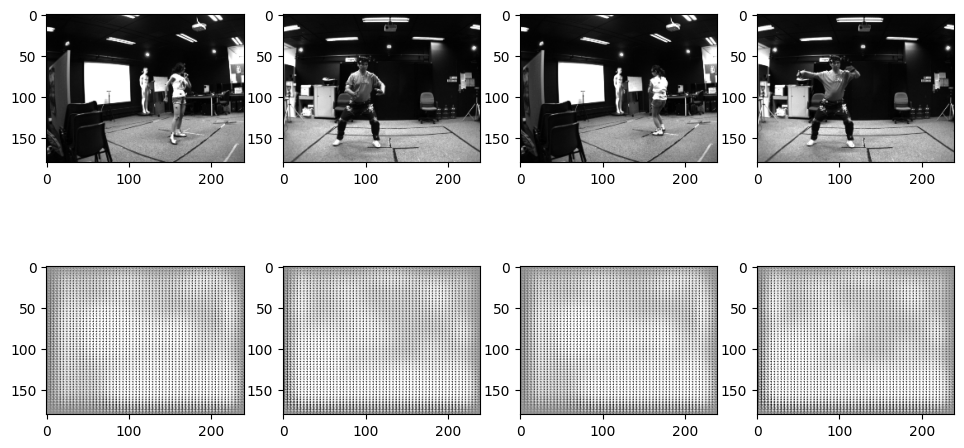

Ground truths vs. model output at epoch 11


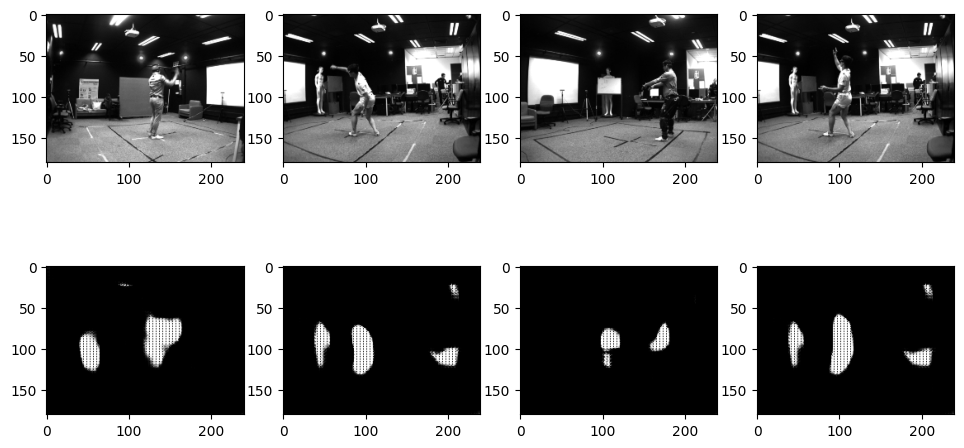

Ground truths vs. model output at epoch 22


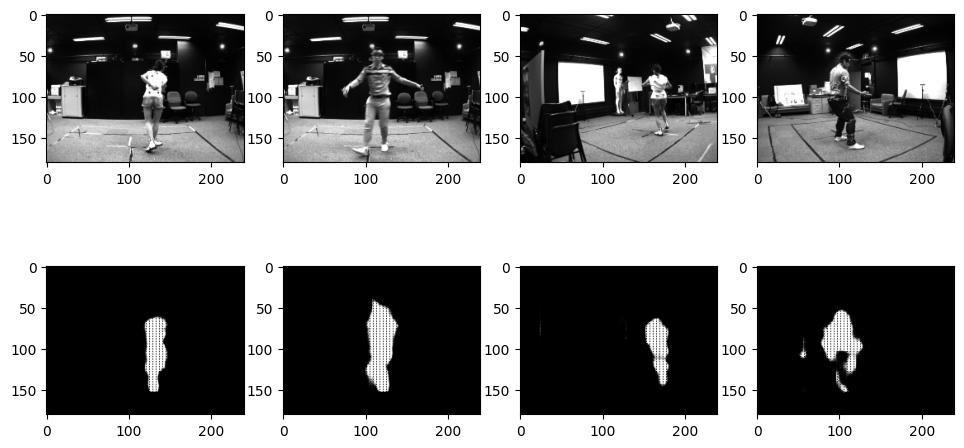

Ground truths vs. model output at epoch 33


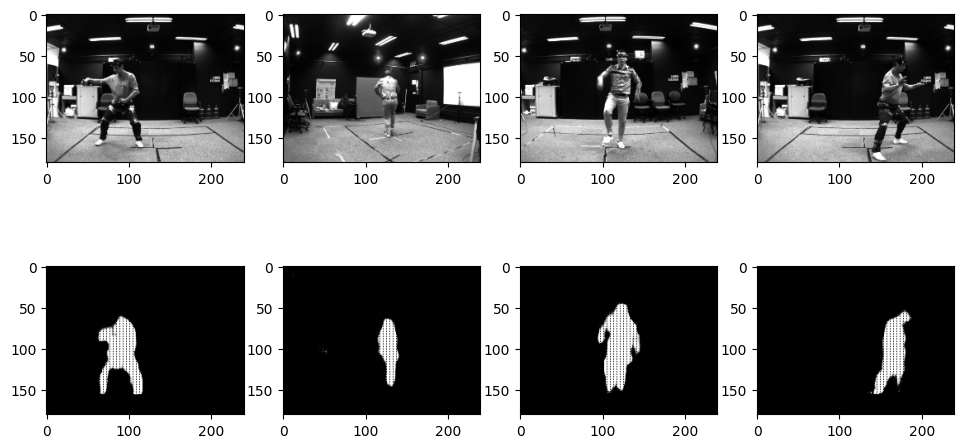

Ground truths vs. model output at epoch 44


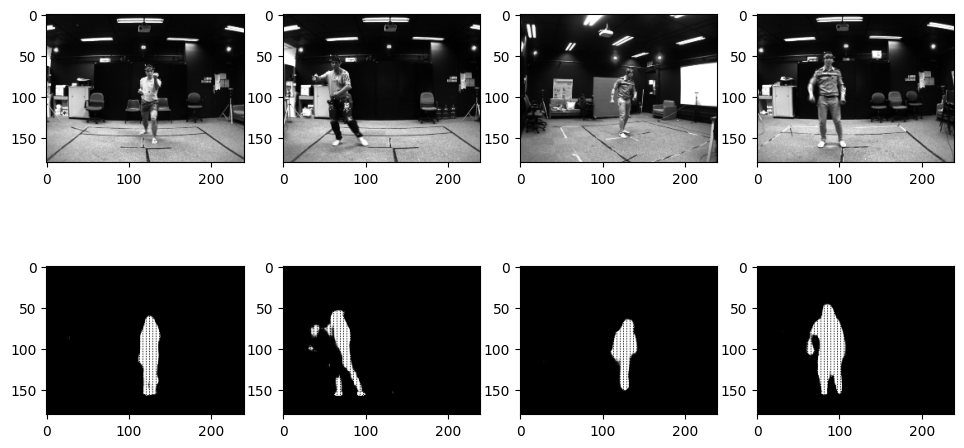

Ground truths vs. model output at epoch 55


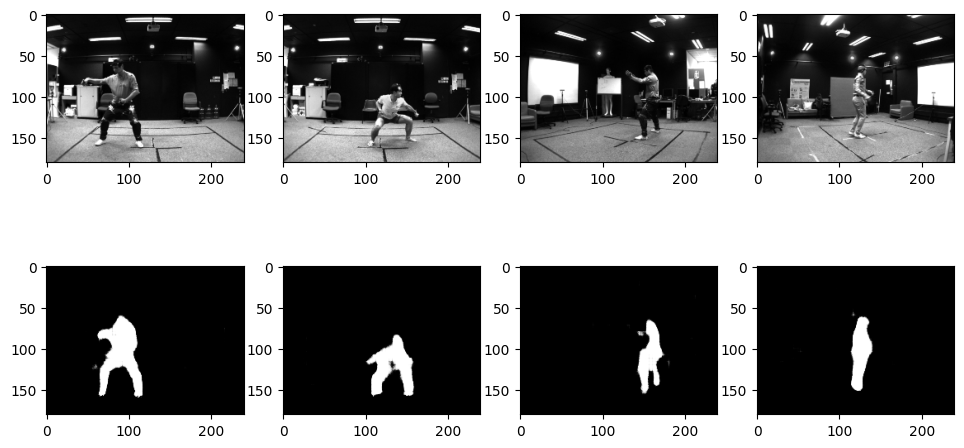

Ground truths vs. model output at epoch 66


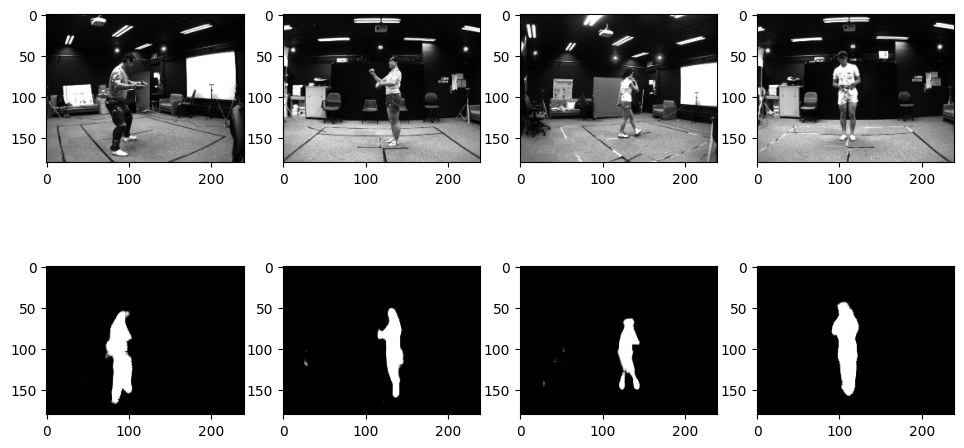

Ground truths vs. model output at epoch 77


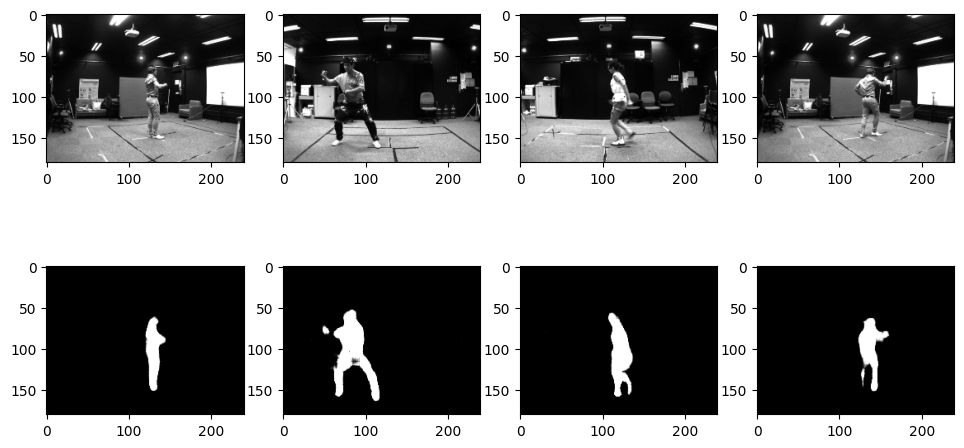

Ground truths vs. model output at epoch 88


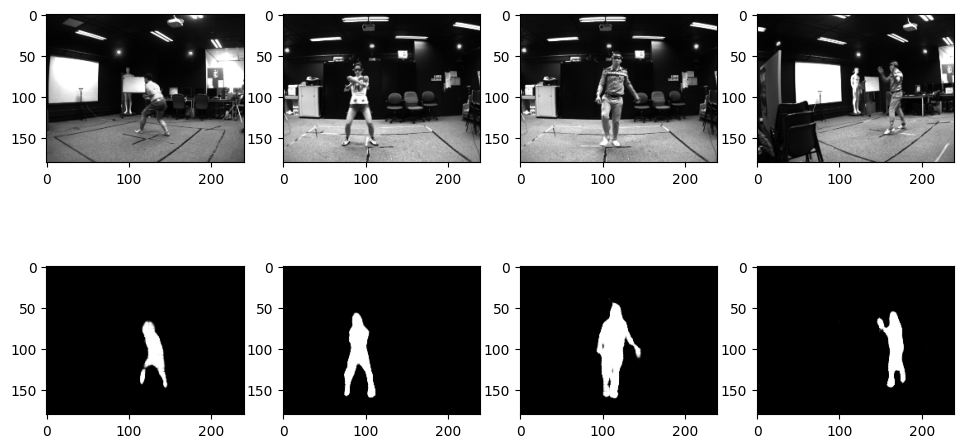

Ground truths vs. model output at epoch 99


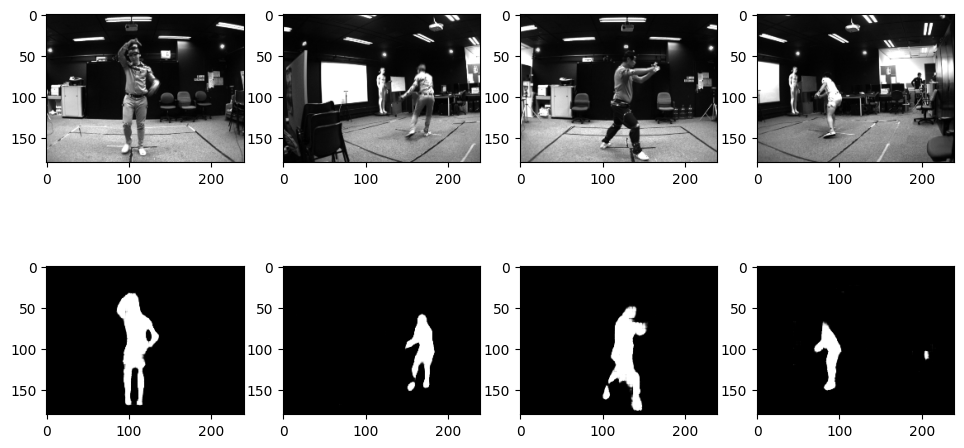

In [265]:
for k in range(0, 100, 11):
    print(f"Images vs. model output at epoch {k}")
    plt.figure(figsize=(27, 6))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 4: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 4: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
    plt.show()

# For test data

In [320]:
# Test data:
masks = np.empty((239,180,240))
truths = np.empty((239,180,240))
outputs2 = []
for idx, (img, truth) in enumerate(test_loader):
    img = img.to(device)
    mask = cnn_encoder(img.squeeze().unsqueeze(dim=1).float())
    outputs2.append((idx, img, mask))
    for item in truth:
        # np.append(truths,np.array(item.detach().cpu()))
        # print(item.shape)
        truths[idx] = item.detach().cpu().numpy()
        
    for item in mask:
        # np.append(masks,np.array(item.detach().cpu()))
        masks[idx] = item.detach().cpu().numpy()

Ground truths vs. model output for test data
(64, 180, 240) (64, 1, 180, 240)


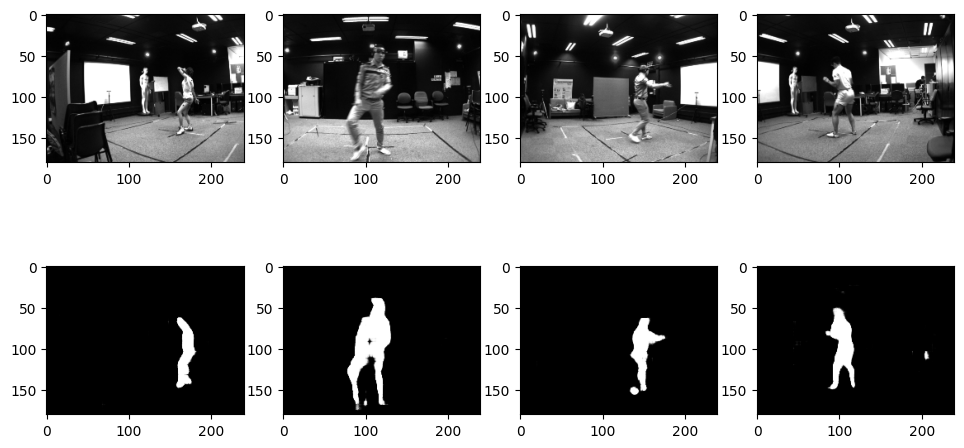

Ground truths vs. model output for test data
(64, 180, 240) (64, 1, 180, 240)


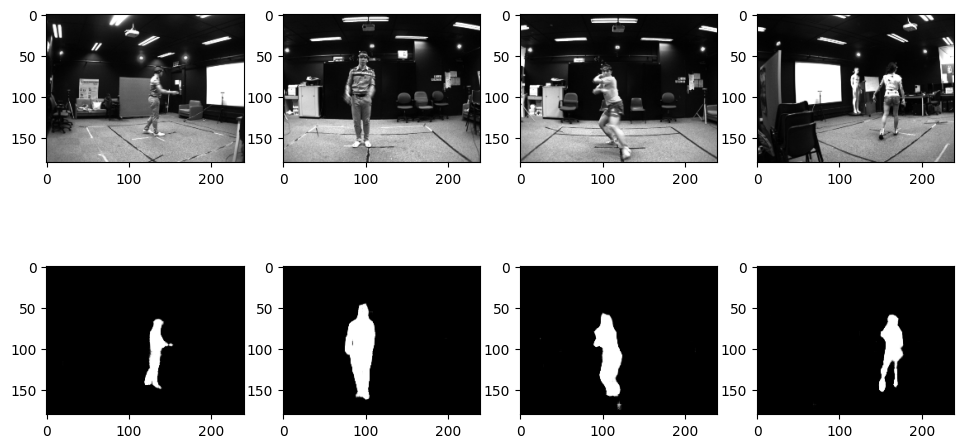

Ground truths vs. model output for test data
(64, 180, 240) (64, 1, 180, 240)


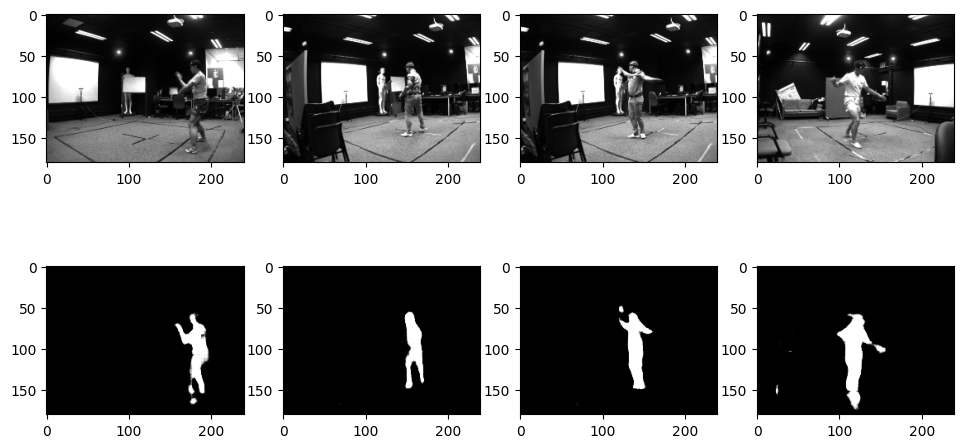

Ground truths vs. model output for test data
(47, 180, 240) (47, 1, 180, 240)


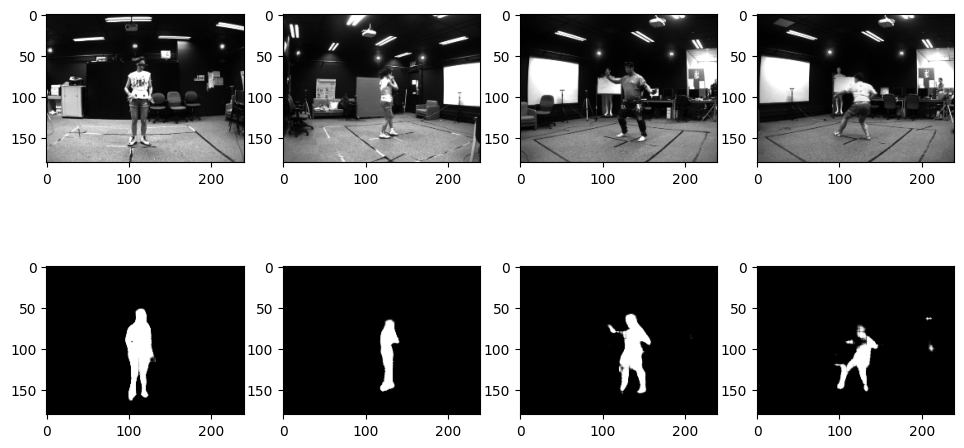

In [295]:
idxs = np.zeros(4,dtype='int16')
for k in range(4):
    print(f"Images vs. model output for test data")
    plt.figure(figsize=(27, 6))
    plt.gray()
    imgs = outputs2[k][1].detach().cpu().numpy()
    recon = outputs2[k][2].detach().cpu().numpy()
    print(imgs.shape,recon.shape)
    for i, item in enumerate(imgs):
        if i >= 4: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        p = np.random.randint(0, 47)
        plt.imshow(imgs[p])
        idxs[i] = p
        
            
    for i, item in enumerate(recon):
        if i >= 4: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        # p = np.random.randint(0, 47)
        plt.imshow(recon[idxs[i]].reshape(180,240,1))
    plt.show()

# Evaluating using DICE and IoU

In [296]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [322]:
truths.shape

(239, 180, 240)

In [324]:
print("Dice coefficient is:",dice_coef(truths,masks))
print("IoU:", iou(truths,masks))

Dice coefficient is: 0.844
IoU: 0.731
